In [1]:
# Copyright 2013-2016 The Salish Sea NEMO Project and
# The University of British Columbia

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
"""Functions for working with geographical data and model results.
"""

'Functions for working with geographical data and model results.\n'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import tidetools
import netCDF4 as nc
import pdb
import pandas as pd
import xarray as xr
%matplotlib inline

In [2]:
def distance_along_curve(lons, lats):
    """Calculate cumulative distance in km between points in lons, lats

    :arg lons: 1D array of longitude points.
    :type lons: :py:class:`numpy.ndarray`

    :arg lats: 1D array of latitude points.
    :type lats: :py:class:`numpy.ndarray`

    :returns: Cummulative point-by-point distance along track in km.
    :rtype: :py:class:`numpy.ndarray`
    """
    dist = np.cumsum(haversine(lons[1:], lats[1:], lons[:-1], lats[:-1]))
    return np.insert(dist, 0, 0)

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.

    Reference: http://www.movable-type.co.uk/scripts/latlong.html

    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`

    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`

    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`

    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`

    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [4]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.0104, 'tol_lat': 0.00388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.011},
        }):
    """Returns the grid co-ordinates of the closest model point
    to a specified lon/lat. If land_mask is provided, returns the closest
    non-land point.

    e.g.
    j, i = find_closest_model_point(-125.5,49.2,model_lons,model_lats,bathy)
    where bathy, model_lons and model_lats are returned from get_bathy_data(grid).
    j is the y-index(latitude), i is the x-index(longitude)

    :arg lon: specified longitude
    :type lon: float

    :arg lat: specified latitude
    :type lat: float

    :arg model_lons: specified model longitude
    :type model_lons: numpy array

    :arg model_lats: specified model latitude
    :type model_lats: numpy array

    :arg grid: specify which default lon/lat tolerances
    :type grid: string

    :arg land_mask: describes which grid co-ordinates are land
    :type land_mask: numpy array

    :arg tols: stored default tols for different grid types
    :type tols: dict

    :returns: yind, xind
    """

    # Search for a grid point with longitude or latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'], model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'], model_lats < lat + tols[grid]['tol_lat']))))
    if j_list.size > 1 or i_list.size > 1:
        # several points within tol, calculate distance for all of them and pick closest
        min_dist = float('Inf')
        for n in range(len(i_list)):
            dist = haversine(lon, lat, model_lons[j_list[n], i_list[n]], model_lats[j_list[n], i_list[n]])
            if dist < min_dist:
                closest_point = (j_list[n], i_list[n])
                min_dist = dist
        j, i = closest_point
    elif not j_list or not i_list:
        raise ValueError(
            'No model point found. tol_lon/tol_lat too small or '
            'lon/lat outside of domain.'
        )
    else:
        i = i_list
        j = j_list

    # If point is on land and land mask is provided, try to find closest water point
    if land_mask is not None and land_mask[j, i]:
        jmax, imax = land_mask.shape
        max_search_dist = int(model_lats.shape[1]/4)  # Limit on size of grid search
        closest_point = None
        j_s, i_s = j, i  # starting points is j, i
        dj, di = 0, -1
        # move j_s, i_s in a square spiral centred at j, i
        while (i_s-i) <= max_search_dist:
            if ((j_s-j) == (i_s-i)
                or ((j_s-j) < 0 and (j_s-j) == -(i_s-i))
                or ((j_s-j) > 0 and (j_s-j) == 1-(i_s-i))
            ):
                # Hit the corner of the spiral- change direction
                dj, di = -di, dj
            i_s, j_s = i_s+di, j_s+dj  # Take a step to next square
            if i_s >= 0 and i_s < imax and j_s >= 0 and j_s < jmax and not land_mask[j_s, i_s]:
                # Found a water point, how close is it?
                actual_dist = haversine(lon, lat, model_lons[j_s, i_s], model_lats[j_s, i_s])
                if closest_point is None:
                    min_dist = actual_dist
                    closest_point = (j_s, i_s)
                elif actual_dist < min_dist:
                    # Keep record of closest point
                    min_dist = actual_dist
                    closest_point = (j_s, i_s)
                # Assumes grids are square- reduces search radius to only
                # check grids that could potentially be closer than this
                grid_dist = int(((i_s-i)**2 + (j_s-j)**2)**0.5)
                if (grid_dist + 1) < max_search_dist:
                    # Reduce stopping distance for spiral-
                    # just need to check that no points closer than this one
                    max_search_dist = grid_dist + 1

        if closest_point is None:
            raise ValueError(
                "Only found land points near that coordinate. If land points are OK don't pass in a land_mask."
            )
        else:
            j, i = closest_point
    return j, i


In [47]:
def find_model_point(lon, lat, X, Y, tol_lon=0.016, tol_lat=0.011):
    """Finds a model grid point close to a specified latitude and longitude.
    Should be used for non-NEMO grids like the atmospheric forcing grid.

    :arg lon: The longitude we are trying to match.
    :type lon: float

    :arg lat: The latitude we are trying to match.
    :type lat: float

    :arg X: The model longitude grid.
    :type X: numpy array

    :arg Y: The model latitude grid.
    :type Y: numpy array

    :arg tol_lon: tolerance on grid spacing for longitude
    :type tol_lon: float

    :arg tol_lat: tolerance on grid spacing for latitude
    :type tol_lat: float

    :returns: j-index and i-index of the closest model grid point.
    """

    # Search for a grid point with longitude or latitude within
    # tolerance of measured location
    j, i = np.where(
        np.logical_and(
            (np.logical_and(X > lon - tol_lon, X < lon + tol_lon)),
            (np.logical_and(Y > lat - tol_lat, Y < lat + tol_lat))))

    if j.size > 1 or i.size > 1:
        raise ValueError(
            'Multiple model points found. tol_lon/tol_lat too big.'
        )
    elif not j or not i:
        raise ValueError(
            'No model point found. tol_lon/tol_lat too small or '
            'lon/lat outside of domain.'
        )
    return j, i

In [2]:
def find_closest_model_point(lon, lat, X, Y, bathy, lon_tol=0.0052,
                             lat_tol=0.00189, allow_land=False):
    """Returns the grid co-ordinates of the closest non-land model point
    to a specified lon/lat.

    e.g. yind, xind = find_closest_model_point(-125.5,49.2,X,Y,bathy)
    where bathy, X and Y are returned from get_bathy_data(grid).
    yind is the y-index(latitude), xind is the x-index(longitude)

    :arg lon: specified longitude
    :type lon: float

    :arg lat: specified latitude
    :type lat: float

    :arg X: specified model longitude
    :type X: numpy array

    :arg Y: specified model latitude
    :type Y: numpy array

    :arg bathy: model bathymetry
    :type bathy: numpy array

    :arg lon_tol: tolerance value for seaching in longitude
    :type lon_tol: float

    :arg lat_tol: tolerance value for searching in latitude
    :type lat_tol: float

    :arg allow_land: whether code should return a land point or closest
                     water point
    :type allow_land: boolean

    :returns: yind, xind
    """
    # Tolerance for searching for grid points
    # (default is approx. distances between adjacent grid points)
    tol1 = lon_tol   # lon
    tol2 = lat_tol   # lat

    # Search for a grid point with lon/lat within tolerance of
    # measured location
    x1, y1 = np.where(
        np.logical_and(
            (np.logical_and(X > lon-tol1, X < lon+tol1)),
            (np.logical_and(Y > lat-tol2, Y < lat+tol2))))

    # check size of arrays so we don't go out of bounds in our search
    xmax, ymax = bathy.shape
    if np.size(x1) != 0:
        x1 = x1[0]
        y1 = y1[0]
        # What if more than one point is returned from this search?
        # Just take the first one...
        #
        # If x1,y1 is masked, search 3x3 grid around.
        # If all those points are masked, search 4x4 grid around, etc.
        for ii in np.arange(1, 100):
            if bathy.mask[x1, y1] and not allow_land:
                for i in np.arange(max(0, x1-ii), min(xmax, x1+ii+1)):
                    for j in np.arange(max(0, y1-ii), min(ymax, y1+ii+1)):
                        if not bathy.mask[i, j]:
                            break
                    if not bathy.mask[i, j]:
                        break
                if not bathy.mask[i, j]:
                    break
            else:
                i = x1
                j = y1
    else:
            i = []
            j = []
    return i, j

In [6]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

(654, 118)


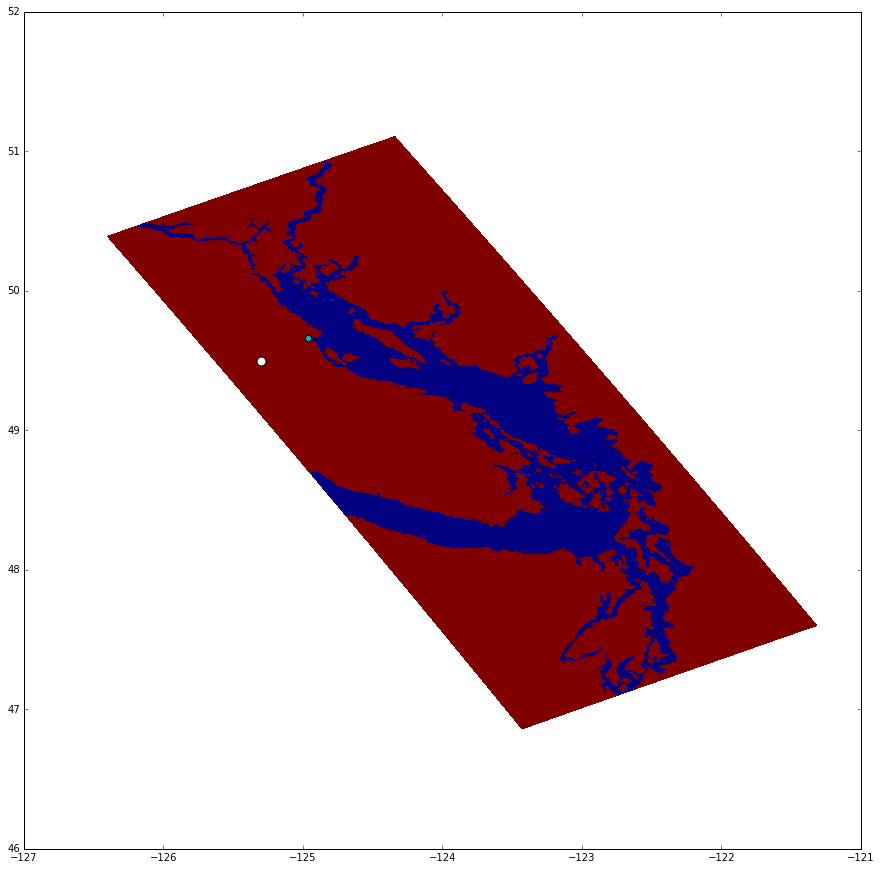

In [10]:
#### print(find_closest_model_point(-124, 48, model_lons = X, model_lats = Y, grid = 'Test', tols = {"Test":{'tol_lat':0.002658843994140625, 'tol_lon':0.0009403228759765625}}, land_mask = bathy.mask))
lon, lat = -125.3, 49.5
#closest_point = find_model_point(lon, lat, X,  Y, tol_lon = 0.0052, tol_lat = 0.00189)
closest_point = find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
print(closest_point)

r1 = max(0, closest_point[0] - 100)
r2 = min(897, closest_point[0] + 100)
c1 = max(0, closest_point[1] - 100)
c2 = min(397, closest_point[1] + 100)

fig, ax = plt.subplots(1, 1,figsize=(15,15))
#plt.pcolormesh(X[r1:r2,c1:c2],Y[r1:r2,c1:c2], (bathy.mask).astype('int')[r1:r2,c1:c2])
plt.pcolormesh(X, Y, (bathy.mask).astype('int'))
plt.scatter([lon], [lat], c = "w" , s =80)
plt.scatter([X[closest_point]], [Y[closest_point]], c = "c" , s =40)
#plt.scatter([X[109,143]], [Y[109,143]], c = "c" , s =40)

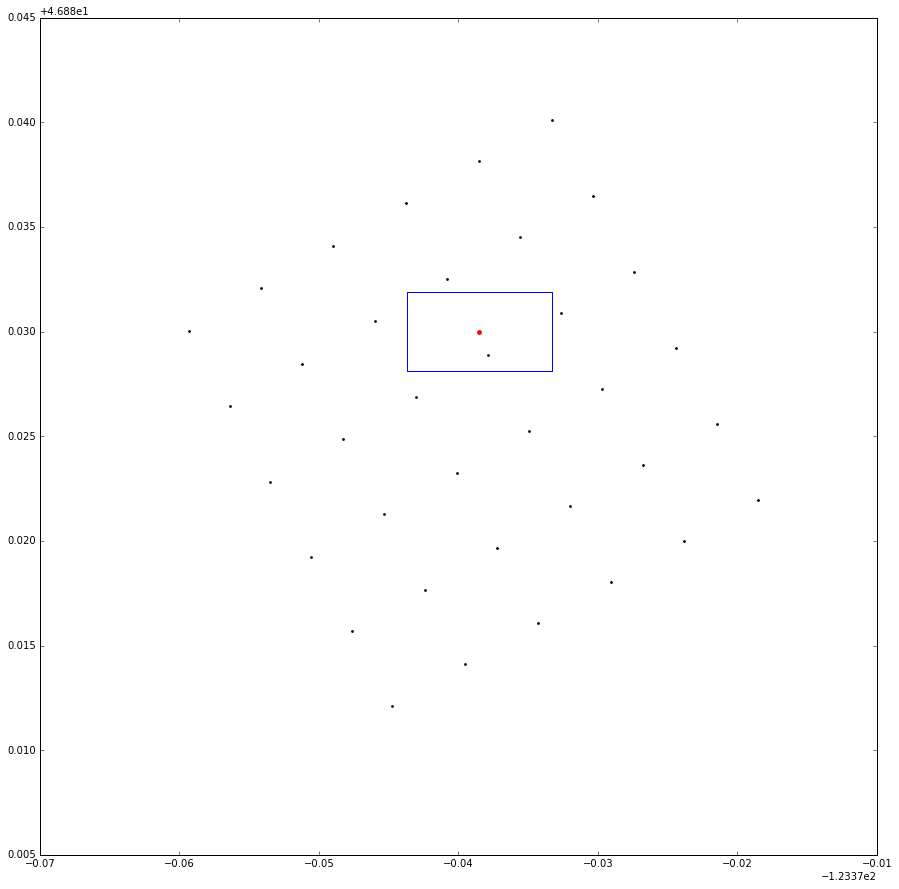

In [131]:
lon, lat = -123.4085, 46.91
tol_lon, tol_lat = 0.0052, 0.00189
fig, ax = plt.subplots(1, 1,figsize=(15,15))
plt.scatter(X[6:12,6:12],Y[6:12,6:12], s =3 )
#plt.scatter([lon], [lat], c = "w" , s =80)
#plt.scatter([X[tuple(reversed(closest_point))]], [Y[tuple(reversed(closest_point))]], c = "c" , s =40)
#plt.scatter([X[109,143]], [Y[109,143]], c = "c" , s =40)
plt.plot([lon + tol_lon, lon + tol_lon, lon - tol_lon, lon - tol_lon,lon + tol_lon],
        [lat - tol_lat, lat + tol_lat, lat + tol_lat, lat - tol_lat,lat - tol_lat])
plt.scatter([lon],[lat], s= 14, color = 'r')

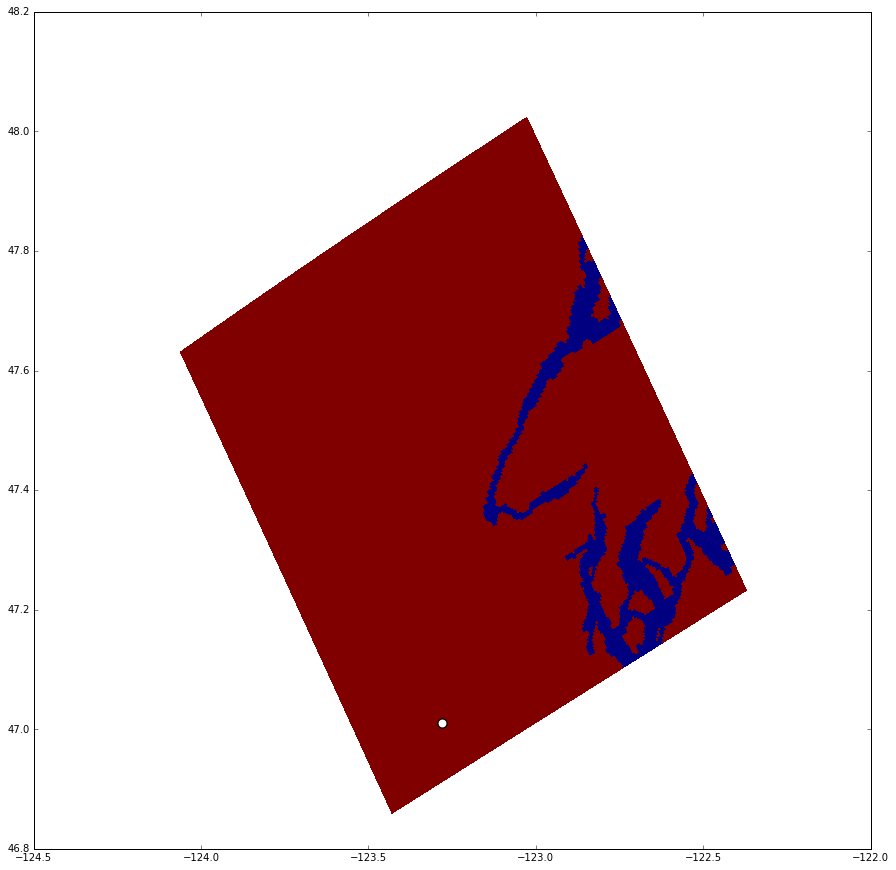

In [72]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
r1,r2,c1,c2 = 0,200,0,200
plt.pcolormesh(X[r1:r2,c1:c2],Y[r1:r2,c1:c2], (bathy.mask).astype('int')[r1:r2,c1:c2])
plt.scatter([X[20,40]], [Y[20,40]], c = "w" , s =80)

lat = 47.5
lon = -123.7

model_lons = X
model_lats = Y
grid = 'NEMO'
tols={'NEMO': {'tol_lon':0.0104, 'tol_lat':0.00388}}
i_list, j_list = np.where(
    np.logical_and(
        (np.logical_and(model_lons > lon - tols[grid]['tol_lon'], model_lons < lon + tols[grid]['tol_lon'])),
        (np.logical_and(model_lats > lat - tols[grid]['tol_lat'], model_lats < lat + tols[grid]['tol_lat']))))
plt.scatter([X[20,40]], [Y[20,40]], c = "w" , s =80)

In [74]:
atmos_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
#print(atmos_grid)
nemo_lon_lat = [-123.7665023803711,49.30873107910156]

atmos_ji = find_closest_model_point(
    nemo_lon_lat[0], nemo_lon_lat[1],
    atmos_grid.longitude.values - 360, atmos_grid.latitude.values,
    grid = "GEM2.5")
print(atmos_ji)

(array([148]), array([139]))


In [299]:
j,i = 0,0
#j_s, i_s = j, i # starting points are i,j
#dj, di = 0, -1 

if (j_s-j) == (i_s-i) or ((j_s-j) < 0 and (j_s-j) == -(i_s-i)) or ((j_s-j) > 0 and (j_s-j) == 1-(i_s-i)):
            # Hit the corner of the spiral- change direction
    dj, di = -di, dj
i_s, j_s = i_s+di, j_s+dj
print((j_s,i_s))

(-5, 5)
